In [1]:
from pathlib import Path
from tqdm.auto import notebook_tqdm

from pytorch_metric_learning import losses
from pytorch_metric_learning import distances
from pytorch_metric_learning import losses
from pytorch_metric_learning import samplers

import numpy as np

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from torchvision.utils import make_grid

In [2]:
def create_headless_resnet18():
    model = models.resnet18(pretrained=True, progress=False)
    model = nn.Sequential(*list(model.children())[:-1])
    return model

In [3]:
model = create_headless_resnet18()

In [4]:
data_path = Path("/home/pau/Documents/datasets/MIT_split")

In [5]:
transfs = transforms.Compose([
    #transforms.ColorJitter(brightness=.3, hue=.3),
    #transforms.RandomResizedCrop(256, (0.15, 1.0)),
    #transforms.RandomRotation(degrees=30),
    #transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(str(data_path / "train"), transform=transfs)
img, label = dataset[0]
out = model(img.unsqueeze(0))
out.squeeze(-1).squeeze(-1)

tensor([[0.8438, 0.9224, 0.9468, 1.0483, 0.9364, 0.7958, 0.8871, 1.2560, 0.9614,
         0.8810, 0.8834, 0.8599, 0.8765, 0.9628, 0.8845, 0.9865, 0.9025, 1.4508,
         0.9544, 0.8010, 0.8607, 1.1033, 0.8806, 1.0488, 0.8884, 0.9262, 0.9648,
         0.9544, 0.9125, 0.8862, 0.8692, 0.8882, 0.9066, 0.8413, 0.8652, 0.8431,
         0.9496, 1.0025, 0.8414, 0.9395, 0.9061, 0.8197, 0.8258, 0.9931, 0.8625,
         0.8785, 0.9710, 1.1020, 0.9160, 0.8791, 0.8893, 0.9902, 0.8627, 0.8711,
         1.0022, 0.9334, 1.2106, 0.8489, 1.0053, 0.9595, 0.8662, 0.9254, 0.9993,
         0.8380, 0.9106, 0.9648, 0.7791, 0.9496, 1.0252, 0.8391, 0.9075, 0.8210,
         0.8894, 0.9001, 0.8610, 0.9140, 0.8744, 0.9258, 0.8549, 0.8776, 0.9329,
         1.0151, 1.0127, 1.2511, 0.8064, 0.9371, 0.9470, 0.8623, 0.9571, 0.7853,
         0.8224, 0.9294, 0.9266, 0.9531, 0.9257, 0.8519, 0.8681, 0.8500, 0.9299,
         0.8515, 0.9982, 0.9669, 0.9893, 0.9690, 0.8763, 0.7863, 0.9496, 0.8780,
         0.8201, 0.9295, 0.8

In [6]:
len(dataset.classes)

8

In [7]:
class_sampler = samplers.MPerClassSampler(
    labels=dataset.classes,
    m=4,
    batch_size=32,
)
dataloader = DataLoader(
    dataset,
    batch_size=32,
    sampler=class_sampler,pin_memory=True
)
optimizer = optim.Adam(model.parameters(), 3E-4)
loss_func = losses.ContrastiveLoss()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), 3E-4)

output_path = Path("./results/jupytest")

In [9]:
writer = SummaryWriter(log_dir=str(output_path))

iters = 0

model.train()
for epoch in range(1):
    print(f"Epoch {epoch} of 100")
    for batch, labels in notebook_tqdm(dataloader, desc="Batch Progress..."):
        batch_size = batch.shape[0]
        batch = batch.to(device)
        optimizer.zero_grad()
        embeddings = model(batch)
        embeddings = embeddings.squeeze(-1).squeeze(-1)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()

        writer.add_scalar("Loss/Train", loss / batch_size, iters)


        iters += 1

torch.save(
    model.state_dict(),
    str(output_path / "weights_final.pth")
)

Epoch 0 of 100


Batch Progress...:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 1 of 100


Batch Progress...:   0%|          | 0/3125 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
torch.save(
    model.state_dict(),
    str(output_path / "weights_final.pth")
)

In [17]:
import matplotlib.pyplot as plt


def showimg(img):
    plt.figure(dpi=150)
    plt.imshow(img)
    plt.show()
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


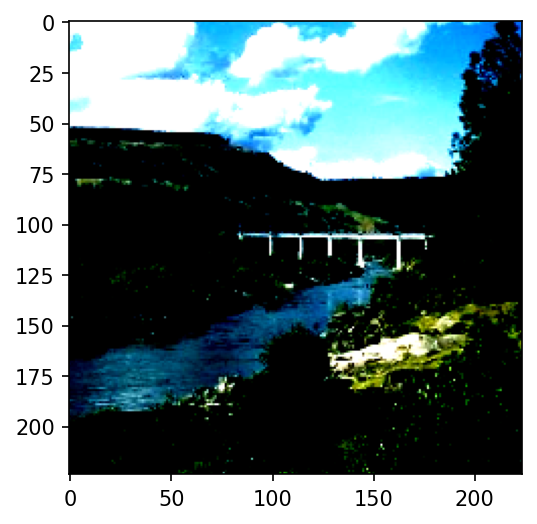

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


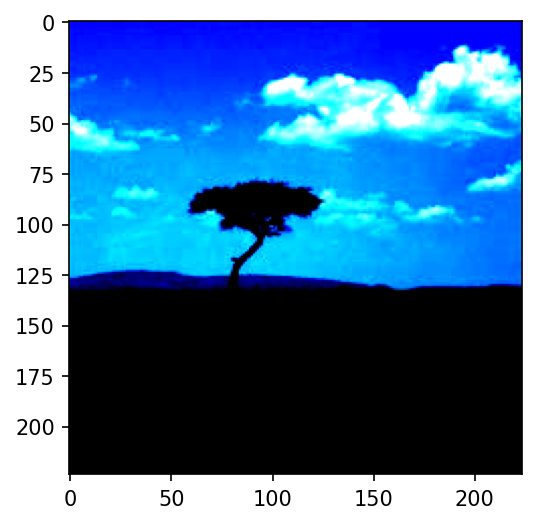

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


True


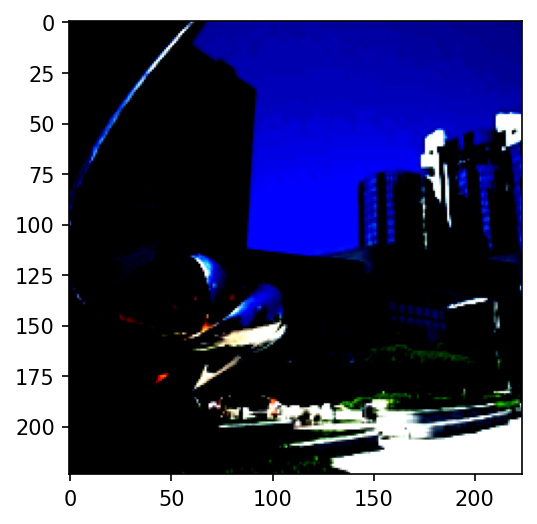

False
tensor(False)
tensor(7.7791)
tensor(4.7973)


In [26]:
with torch.no_grad():
    model.eval()
    cpu_model = model.cpu()

    img1, label1 = dataset[0]
    showimg(img1.permute((1, 2, 0)).numpy())

    img2, label2 = dataset[1]
    showimg(img2.permute((1, 2, 0)).numpy())
    print(label1 == label2)

    img3, label3 = dataset[-1]
    showimg(img3.permute((1, 2, 0)).numpy())
    print(label1 == label3)

    embed1 = cpu_model(img1.unsqueeze(0)).squeeze(-1).squeeze(-1)
    embed2 = cpu_model(img2.unsqueeze(0)).squeeze(-1).squeeze(-1)
    embed3 = cpu_model(img3.unsqueeze(0)).squeeze(-1).squeeze(-1)

    print((embed1 - embed2).pow(2).sum().sqrt() < (embed1 - embed3).pow(2).sum().sqrt())
    print((embed1 - embed2).pow(2).sum().sqrt())
    print((embed1 - embed3).pow(2).sum().sqrt())